In [1]:
rm(list=ls())
library(susieR)
data(N3finemapping)
attach(N3finemapping)

In [2]:
y = Y[,1]
b = true_coef[,1]

**Question: Please use R function `plot` to visualize the true effects vector. What are the effect sizes for these 3 "causal" variants?**

**Answer:**

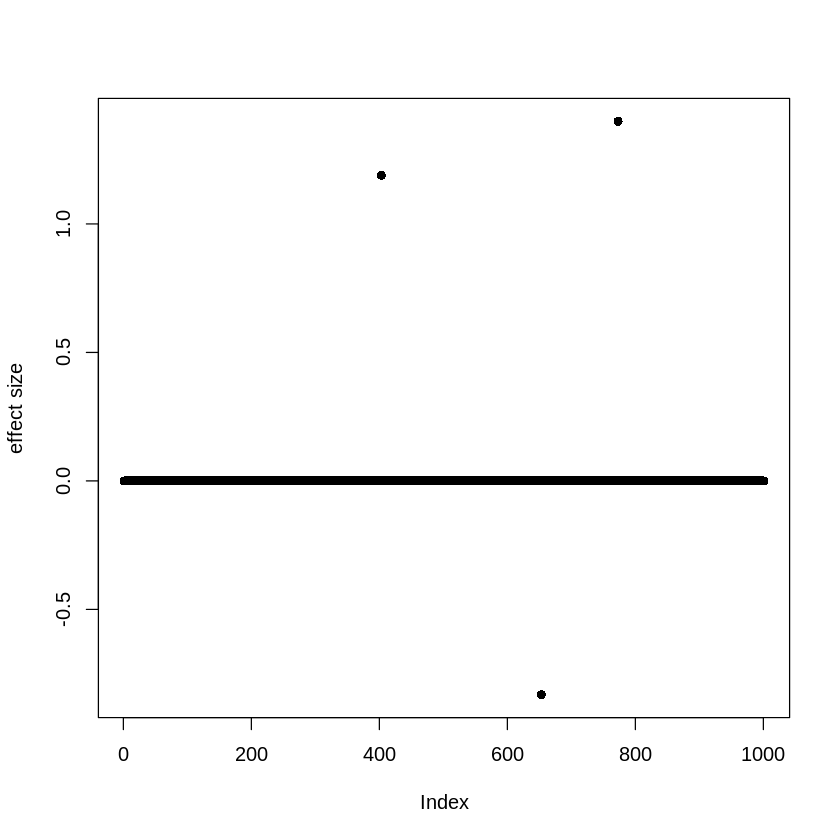

In [3]:
plot(b, pch=16, ylab='effect size')

The effect size of the 3 effect variants are: 

In [4]:
b[which(b != 0)]

[1]  1.189172 -0.831789  1.399288

In [5]:
sumstats <- univariate_regression(X, y)

**Question: Please use R function plot to compare the true effects variable `b` with the estimated effect sizes `sumstats$betahat`. Are they consistent, and why?**

**Answer:**

The estimated effect sizes (`sumstats$betahat`) are:

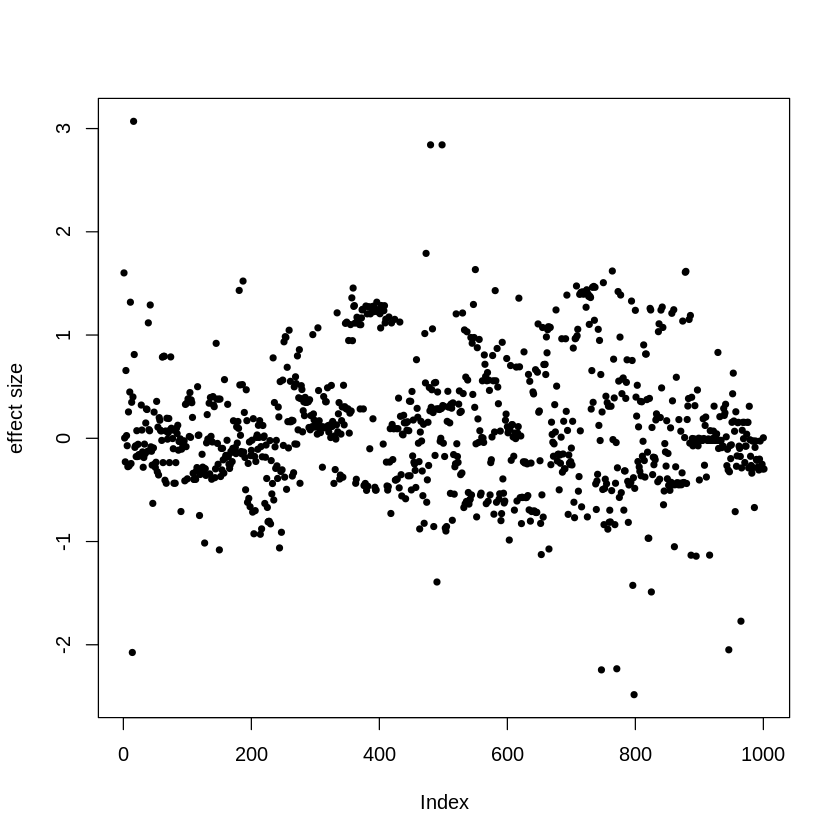

In [6]:
plot(sumstats$betahat, ylab='effect size',pch=20)

We add the true effects `b` in red to compare with the estimated effect sizes `sumstats$betahat` in black:

integer(0)

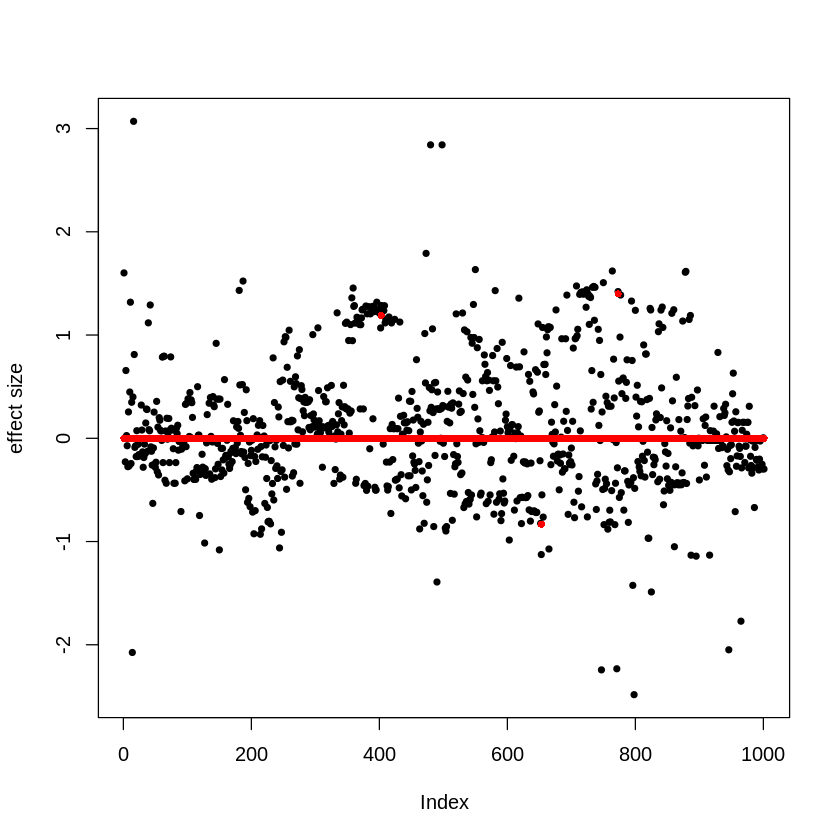

In [7]:
plot(sumstats$betahat, ylab='effect size',pch=20)+
points(b,col=2,pch=16,cex=0.8)

The estimated effects via univariate regression are very different from the simulated true effects. Many non-effect variables show large effects (and z-scores, see below) due to inflation induced by linkage disequilibrium (LD) with the effect variables.

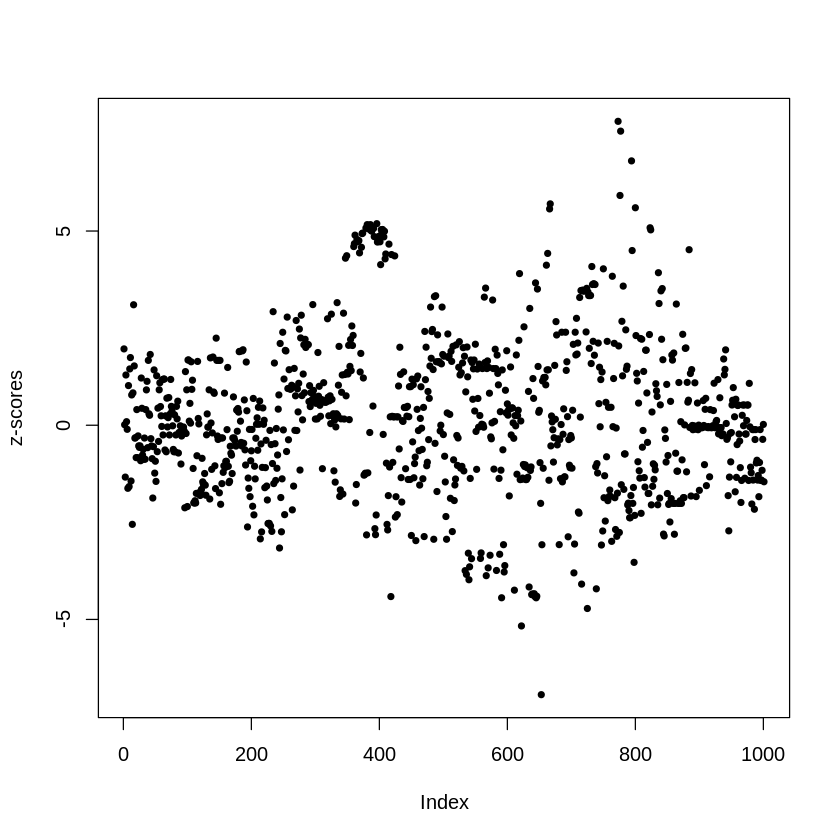

In [8]:
plot(sumstats$betahat/sumstats$sebetahat, ylab='z-scores',pch=20)

Below is visualization of correlations between variables near the first effect variable, showing high correlations between variants in genetic data:

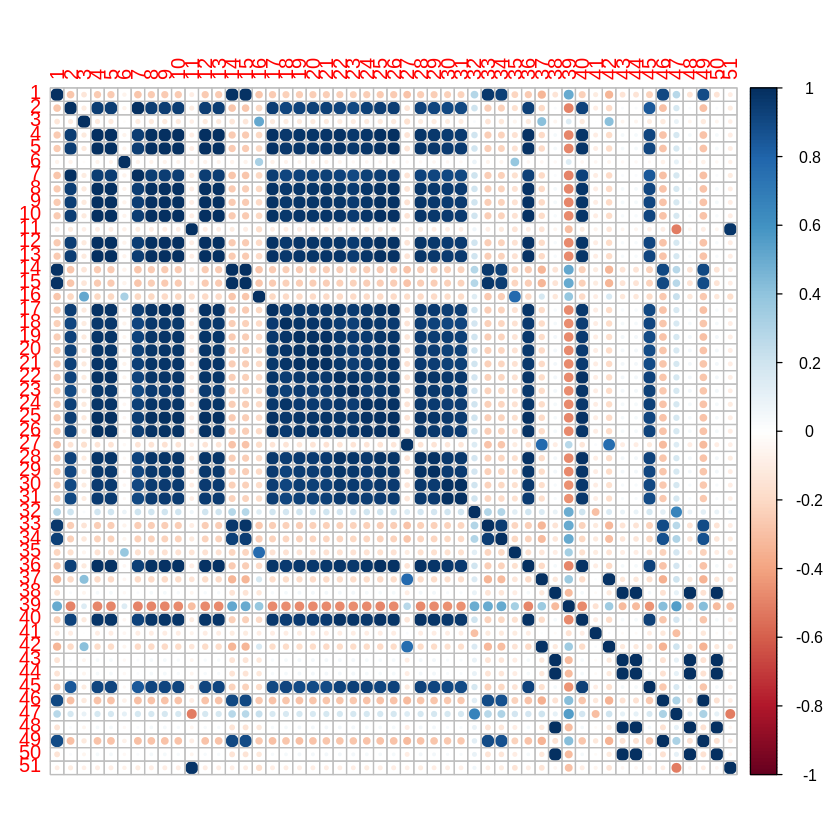

In [9]:
corrplot::corrplot(cor(X[,380:430]))

In [10]:
z_scores <- sumstats$betahat / sumstats$sebetahat
log10p <- -log10(pchisq(z_scores^2,1,lower.tail=F))

**Question: How many variables have p-values smaller than $10^{-8}$? Would you report all of them as significant association findings, and if not, which variable(s) will you likely report, based on univariate association analysis?**

**Answer:**

In [11]:
gwas_sig = which(log10p>8)
cat (length(gwas_sig),'variables have p-values smaller than 10^-8.')

5 variables have p-values smaller than 10^-8.

Correlation between these variables are very high:

In [12]:
gwas_sig

[1] 653 773 776 777 794

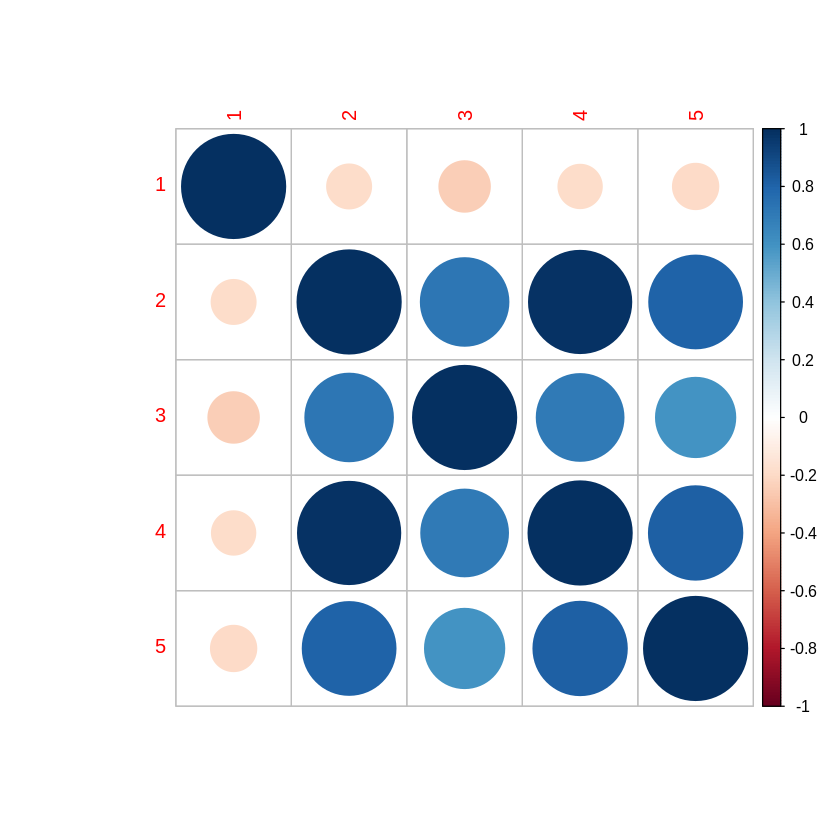

In [13]:
corrplot::corrplot(cor(X[,gwas_sig]))

Given the high correlations among these variables, it is very likely that only 1 out of the 5 variables is the true effect variable. Without performing formal analysis to account for LD, the variable with smallest p-value from this cluster of highly correlated variables are typically reported as the "causal" variable.

In [14]:
lliks = sapply(1:ncol(X), function(i) logLik(lm(y~X[,i])))

In [15]:
lliks = lliks - max(lliks) # To avoid taking exp on large numbers in the next line, thus improving numerical stability 
probs = exp(lliks)/sum(exp(lliks))

In [16]:
which(susieR:::in_CS(t(probs), coverage = 0.95) != 0)

[1] 773 777

**Question: Show the p-values and probabilities of non-zero effect for these two variables. Compute the correlation between these two variables, and commment on result for the zero effect variable `777`**.

**Answer**

In [17]:
cat("−𝑙𝑜𝑔10  p-values from above:")
log10p[c(773,777)]
cat("p-values:")
10^-(log10p[c(773,777)])

−𝑙𝑜𝑔10  p-values from above:

[1] 14.29310 13.43417

p-values:

[1] 5.092186e-15 3.679810e-14

In [18]:
cat("'causal' probability:")
probs[c(773,777)]

'causal' probability:

[1] 0.8517900 0.1451795

Correlation

In [19]:
cor(X[,773],X[,777])

[1] 0.9815726

The zero-effect variable `777` shows a small p-value because it is highly correlated (0.98 Pearson's correlation) with the effect variable `773`. However, under the assumption that only one variable is non-zero effect, the probability of `773` being the variable is much higher than that for `777`. In this example, statistical fine-mapping performs quite well even though correlations between variables are high.

In [20]:
fitted <- susie(X, y, L = 10)

In [21]:
sets <- susie_get_cs(fitted, X = X, coverage = 0.9)

**Question: why is the size for the 3rd CS smaller and minimum absolute correlation higher, when requesting 90% coverage compared to previous result of requesting 95%?**

**Answer:**

By definition of CS, less variables are needed to sum up to 90% compared to that needed to sum up to 95%. Because less variables are involved, the size of CS are smaller and the minimum correlation between variables are higher.

**Question: Report the PIP for variable 403. Why is the PIP relatively low for this true effect variable?** You can use the code below to compare $-log_{10}$ p-value and PIP for the CS containing variable 403:

In [22]:
i  <- fitted$sets$cs$L3
z3 <- cbind(i,log10p[i],fitted$pip[i])
colnames(z3) <- c('position', '-log10 pvalue', 'PIP')

**Answer:**

In [23]:
z3[z3[,1]==403,'PIP']

PIP 
0.03199285

In [24]:
sum(fitted$pip[i])

[1] 0.9539815

In [25]:
length(i)

[1] 27

In [26]:
min(cor(X[,i]))

[1] 0.8686309

Because 27 variants are captured in the CS and these variables are highly correlated (at least 0.86 in Pearson's correlation), the probability of any given variable being the effect variable is small, even though collectively the probability of any of them has non-zero effect is high (greater than 0.95).

**Question: Please rerun the `susie` analysis setting `L=1` to detect a maximum of only one effect across the region. How does the result compare to the previous section of "one causal effect" fine-mapping using likelihoods from univariate analysis?**

**Answer:**

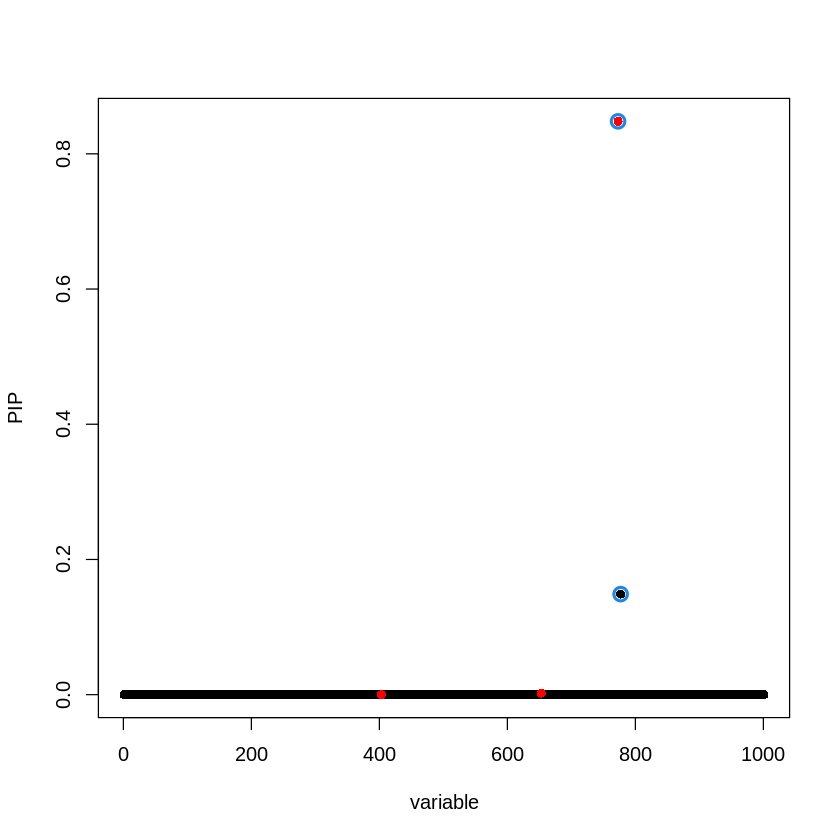

In [27]:
fitted_1 <- susie(X, y, L = 1)
susie_plot(fitted_1, y="PIP", b=b)

The result here is similar with the previous section of "one causal effect" fine-mapping using likelihoods from univariate analysis, although here Bayesian regression analysis were performed instead of linear regression implemented in `lm()` in R.

**Question: Please change `scaled_prior_variance` to different numbers between 0 and 1, and examine the results. What happens if you set it to 0.001, and why?**

**Answer:**

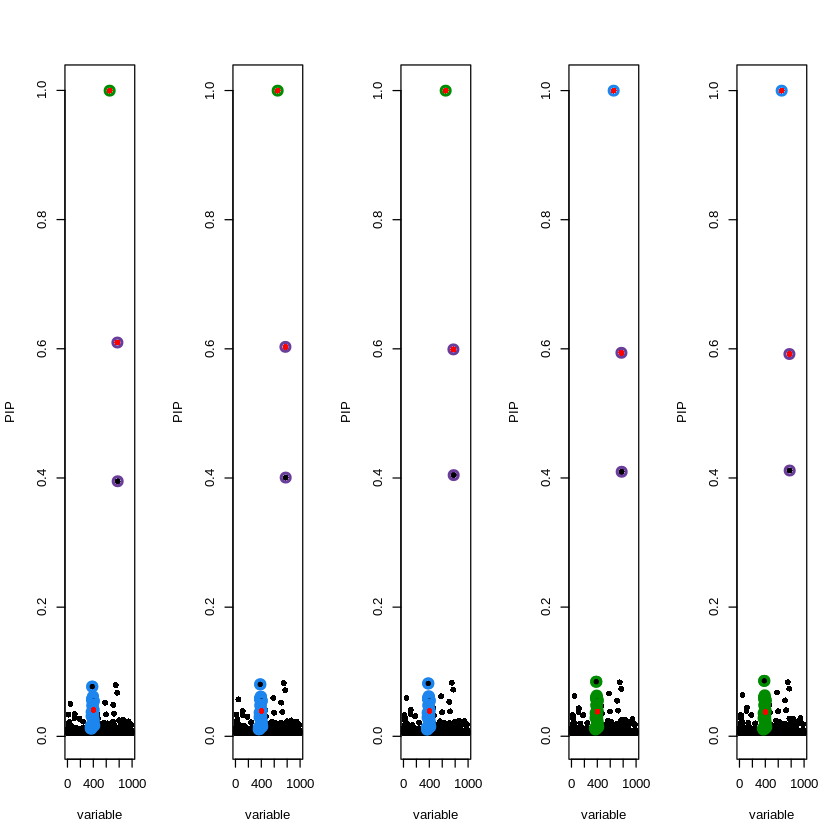

In [28]:
par(mfrow=c(1,5)) 

fitted_3 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.01)
susie_plot(fitted_3, y='PIP', b=b)

fitted_4 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.02)
susie_plot(fitted_4, y='PIP', b=b)

fitted_5 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.03)
susie_plot(fitted_5, y='PIP', b=b)

fitted_6 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.1)
susie_plot(fitted_6, y='PIP', b=b)

fitted_7 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.8)
susie_plot(fitted_7, y='PIP', b=b)

The results are robust to the choice of prior effect size, suggesting that there is strong enough signal in data and the results are mostly driven by data rather than by prior effect size specified.

Very small prior effect reflects the belief that a variable should only contribute to a very small proportion of variation in response. For example if we assume a variant should explain only 0.1% of heritability,

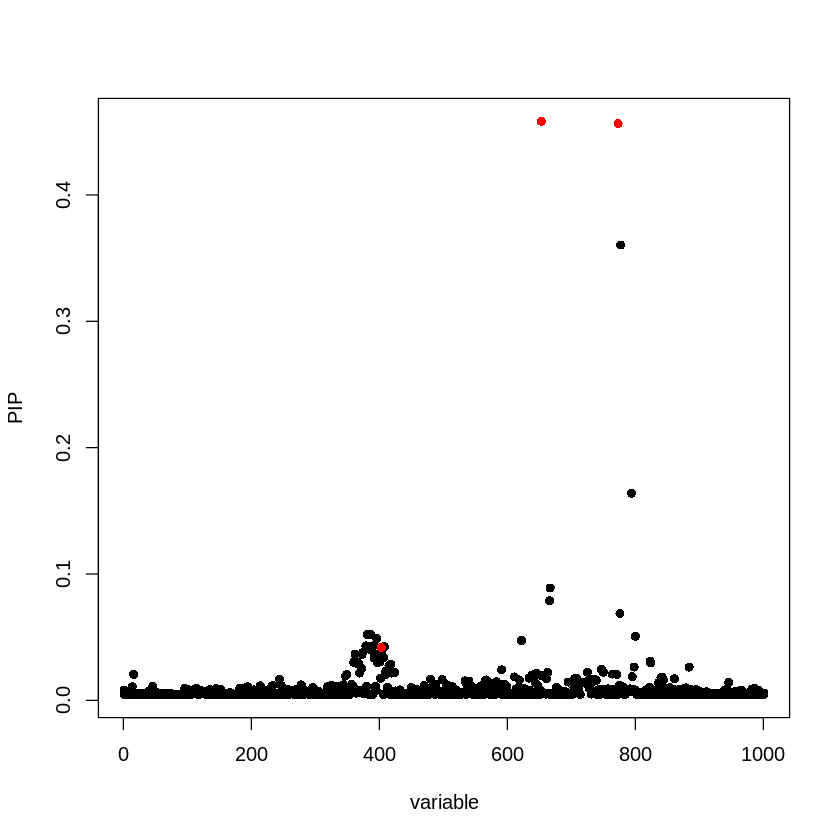

In [29]:
fitted_7 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.001)
susie_plot(fitted_7, y='PIP', b=b, add_legend=T)

The true effects are still identified, but the PIP is low because the very small prior nudges the posterior estimates towards zero.

In [30]:
R <- cor(X)

In [31]:
fitted_rss <- susie_rss(z_scores, R, L = 10)

In [32]:
set.seed(1234)
tmp = matrix(rnorm(500*1001), 500, 1001)
eigenR = eigen(R)
eigenR$values[eigenR$values < 1e-10] = 0
X_ref = tmp %*% (eigenR$values * t(eigenR$vectors))
R_ref = cor(X_ref)

In [33]:
fitted_rss_ref <- susie_rss(z_scores, R_ref, L = 10)

In [34]:
n_ref = 500
fitted_rss_ref_corrected <- susie_rss(z_scores, R_ref, z_ld_weight = 1/n_ref, L = 10)

Please use the same R code for `N3finemapping` data to analyze this new data-set, similarly focusing on the first column of the phenotype matrix as the phenotype of interest. 
This data-set contains two true effect variables. However, as you are soon to find out in univariate linear regression analysis, **the lead SNP via univariate analysis is neither of the two effect variables**.

In [35]:
data(N2finemapping)

**Question: Perform fine-mapping under "one causal variant" assumption. Does it capture any true effect? Does fine-mapping with SuSiE capture all true effects?**

**Answers:**

In [36]:
dim(N2finemapping$X)
dim(N2finemapping$Y)
y_2 = N2finemapping$Y[,1]
b_2 = N2finemapping$true_coef[,1]
which(b_2 != 0)

[1]  574 1002

[1] 574   2

[1] 337 999

In [37]:
sumstats_2 <- univariate_regression(N2finemapping$X, y_2)
z_scores_2 <- sumstats_2$betahat / sumstats_2$sebetahat
log10p_2 <- -log10(pchisq(z_scores_2^2,1,lower.tail=F))

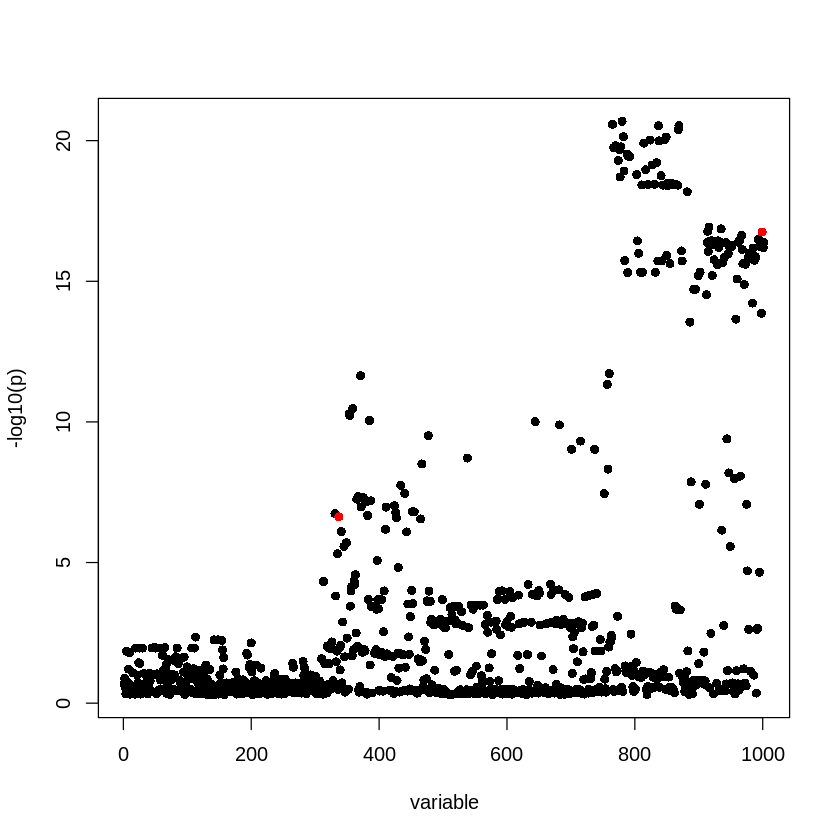

In [38]:
susie_plot(z_scores_2,y="z",b=b_2)

**One causal assumption:**

In [39]:
lliks_2 = sapply(1:ncol(N2finemapping$X), function(i) logLik(lm(y_2~N2finemapping$X[,i])))
lliks_2 = lliks_2 - max(lliks_2) # To avoid taking exp on large numbers in the next line, thus improving numerical stability 
probs_2 = exp(lliks_2)/sum(exp(lliks_2))

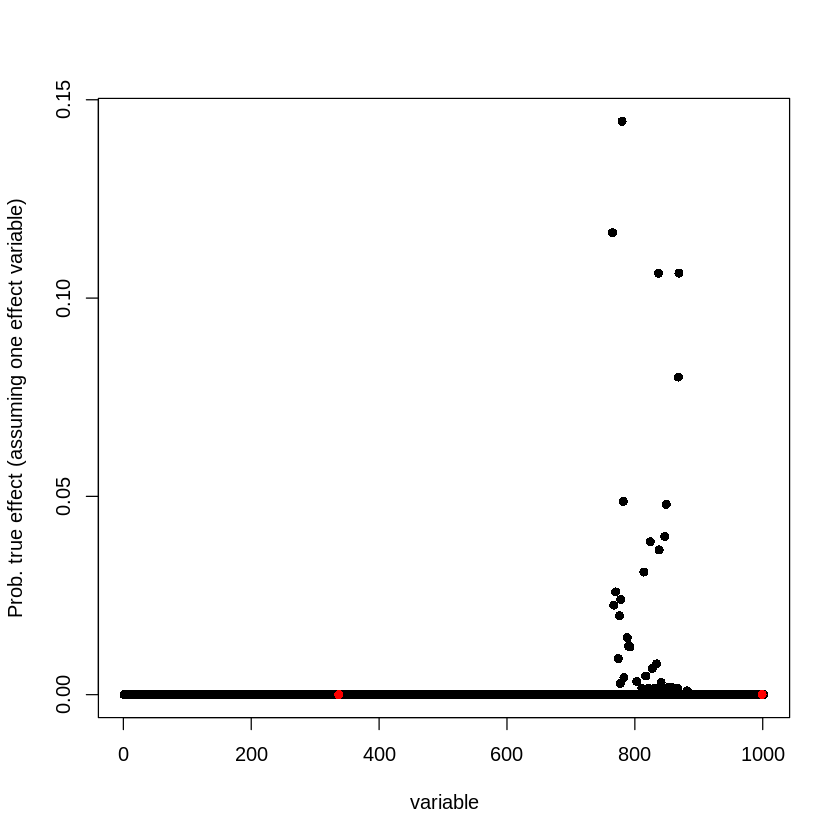

In [40]:
susie_plot(probs_2, y="PIP", b=b_2, ylab = "Prob. true effect (assuming one effect variable)")

As expected, under the "one causal variant" assumption, neither of the true effect variables in red is identified.

**SuSiE Fine mapping:**

**95% credible sets:**

In [41]:
fitted_N2 <- susie(N2finemapping$X, y_2, L = 2)
print(fitted_N2$sets)

$cs
$cs$L2
 [1]  850  913  914  915  916  920  924  925  926  927  930  931  933  934  935
[16]  942  946  948  951  952  962  967  968  979  980  982  983  985  988  989
[31]  993  994  996  999 1000 1001 1002

$cs$L1
[1] 337 379 440


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    0.9722386     0.9939738       0.9949722
L1    0.8534981     0.9183993       0.8944609

$cs_index
[1] 2 1

$coverage
[1] 0.9545953 0.9696343

$requested_coverage
[1] 0.95



**90% credible sets:**

In [42]:
sets_2 <- susie_get_cs(fitted_N2, X = N2finemapping$X, coverage = 0.9)
print(sets_2)

$cs
$cs$L1
[1] 337

$cs$L2
 [1]  913  914  915  916  920  925  926  927  930  931  933  934  935  942  948
[16]  951  952  962  967  968  979  985  988  993  994  996  999 1000 1001 1002


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L1    1.0000000     1.0000000       1.0000000
L2    0.9780338     0.9948644       0.9954347

$cs_index
[1] 1 2

$coverage
[1] 0.912284 0.900496

$requested_coverage
[1] 0.9



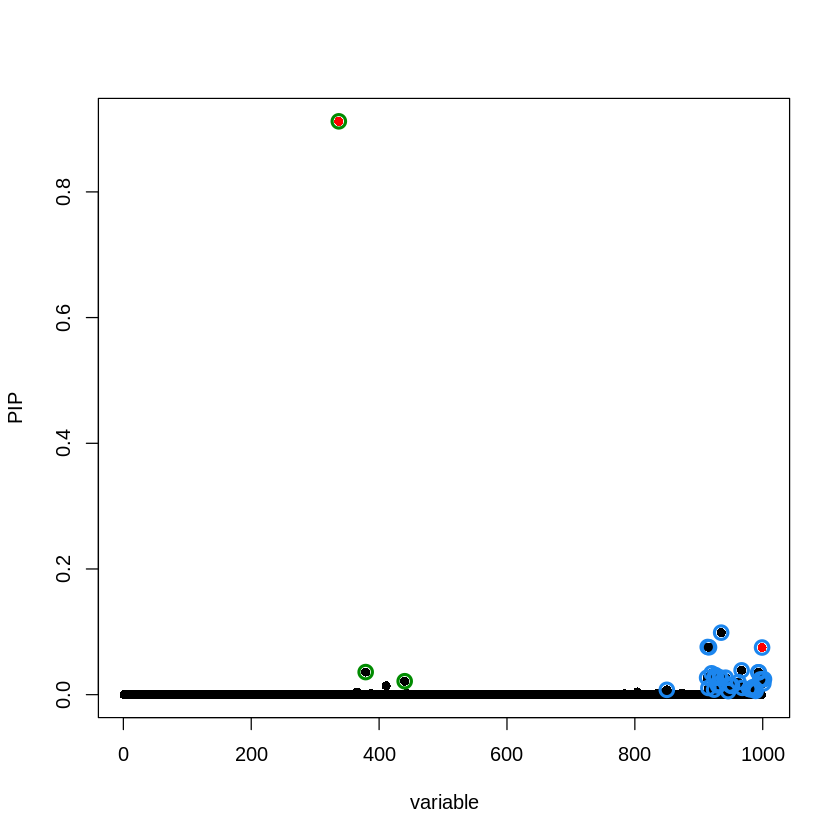

In [43]:
susie_plot(fitted_N2, y="PIP", b=b_2)

Fine-mapping assuming more than one effect captures both simulated true effects.